# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.233095,False,0.051793
1,0.154879,True,5.624716
2,-2.053761,False,-2.132995
3,-1.521739,False,-1.203009
4,1.293783,False,0.259044
...,...,...,...
995,-0.448207,False,0.005774
996,-0.438602,True,4.766975
997,-0.330386,True,3.057610
998,-0.866487,False,-0.671404


<AxesSubplot: xlabel='v0'>

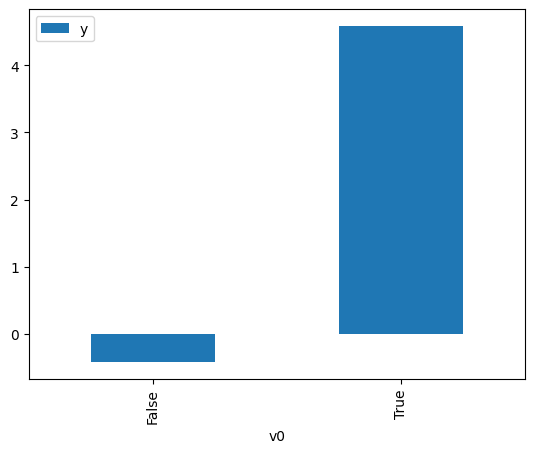

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

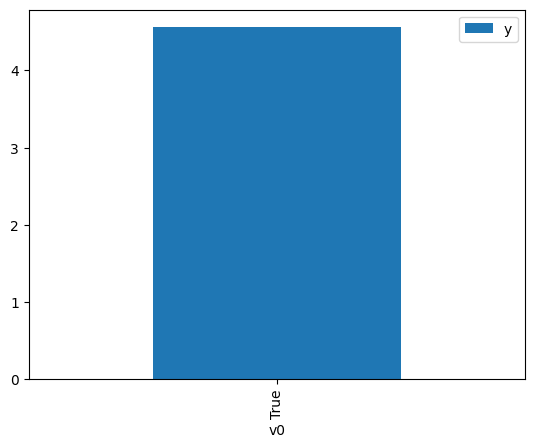

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.125816,False,-0.656390,0.524950,1.904944
1,-0.128129,False,-0.502759,0.525326,1.903578
2,-0.131679,False,1.249694,0.525905,1.901486
3,2.223567,False,0.993158,0.192413,5.197145
4,-2.612855,False,-2.785503,0.848652,1.178339
...,...,...,...,...,...
995,-1.199767,False,-1.369316,0.690239,1.448774
996,-1.174155,False,-0.979949,0.686651,1.456343
997,-0.895137,False,1.037601,0.646181,1.547554
998,0.054776,False,2.115230,0.495486,2.018219


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.090826,True,2.554525,0.325175,3.075271
1,-0.119291,True,5.148743,0.476113,2.100342
2,0.039926,True,5.944262,0.502089,1.991678
3,-0.889429,True,6.015040,0.354672,2.819510
4,-1.107974,True,4.386551,0.322722,3.098641
...,...,...,...,...,...
995,0.655576,True,6.475409,0.601187,1.663376
996,-0.388833,True,4.203132,0.432503,2.312125
997,-1.108057,True,4.850227,0.322710,3.098755
998,-1.187630,True,6.577533,0.311458,3.210703


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              5146.
Date:                Mon, 14 Nov 2022   Prob (F-statistic):                        0.00
Time:                        22:17:17   Log-Likelihood:                         -1412.2
No. Observations:                1000   AIC:                                      2828.
Df Residuals:                     998   BIC:                                      2838.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6934      0.027     26.082      0.000       0.641       0.746
x2             4.9830      0.050    100.483      0.000       4.886       5.080
==============================================================================
Omnibus:                        0.116   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.944   Jarque-Bera (JB):                0.064
Skew:                          -0.015   Prob(JB):                        0.968
Kurtosis:                       3.026   Cond. No.                         1.89
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""